In [1]:
!pip install nltk
#!pip install spacy
!python -m nltk.downloader averaged_perceptron_tagger
!pip install --upgrade nltk
!pip install transformers
!pip install torch torchvision
!pip install --upgrade diffusers accelerate transformers
# !pip install controlnet_aux


<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import gutenberg
#from nltk import pos_tag
import random
#import spacy
from transformers import pipeline


# PROMPT GENERATION

## Random words

In [3]:
# Download the WordNet dataset
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Backups
nouns = list(wn.all_synsets('n'))
adjectives = list(wn.all_synsets('a'))
verbs = list(wn.all_synsets('v'))
random_noun = random.choice(nouns).lemmas()[0].name()
random_adjective = random.choice(adjectives).lemmas()[0].name()
random_verb = random.choice(verbs).lemmas()[0].name()

## Random words from famous artists

In [3]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /home/jovyan/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [4]:
book_complete = gutenberg.words('austen-emma.txt')
austen_emma = ' '.join([word for word in book_complete if word.isalpha()])

In [5]:
nltk.data.path.append("/home/jovyan/nltk_data")  # Ensure the correct path is used
nltk.download('punkt')

nltk.download('averaged_perceptron_tagger', download_dir='/home/jovyan/nltk_data')
nltk.download('punkt_tab')  # This will download the missing tokenizer files

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
pipe = pipeline("token-classification", model="vblagoje/bert-english-uncased-finetuned-pos", device=0)

Some weights of the model checkpoint at vblagoje/bert-english-uncased-finetuned-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def prompt_generation(text):

    def chunk_text(text, max_length=512):
        words = text.split()  # Split text into words
        chunks = []
        current_chunk = []
    
        # Iterate over words and form chunks
        for word in words:
            if len(" ".join(current_chunk + [word])) <= max_length:
                current_chunk.append(word)
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [word]
                
        # Add the last chunk if it exists
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        return chunks
        
    # Chunk the input text
    chunks = chunk_text(text)
    
    # Initialize lists to store words by POS
    nouns = []
    verbs = []
    adjectives = []
    
    # Process each chunk and classify POS
    for chunk in chunks:
        word_classification = pipe(chunk)
        
        for word in word_classification:
            pos = word.get('entity')
            word_text = word.get('word')
            
            if pos == 'NOUN':
                nouns.append(word_text)
            elif pos == 'VERB':
                verbs.append(word_text)
            elif pos == 'ADJ':
                adjectives.append(word_text)
                
    # Filter out tokenized words starting with ##
    nouns = [word for word in nouns if not word.startswith("##")]
    verbs = [word for word in verbs if not word.startswith("##")]
    adjectives = [word for word in adjectives if not word.startswith("##")]

    # Check if lists are non-empty before selecting random words
    prompt_components = []
    
    if adjectives:
        prompt_components.append(random.choice(adjectives))
    if nouns:
        prompt_components.append(random.choice(nouns))
    if verbs:
        prompt_components.append(random.choice(verbs))
    if adjectives:
        prompt_components.append(random.choice(adjectives))
    if nouns:
        prompt_components.append(random.choice(nouns))
    
    # Join the prompt components
    prompt = ' '.join(prompt_components)
    
    return prompt


In [9]:
random.seed(15)

prompt = prompt_generation(austen_emma)
prompt

'contrary subject hearing small law'

# IMAGE GENERATION

## N°1

In [3]:
import requests
from PIL import Image, ImageOps, ImageDraw
from io import BytesIO
from diffusers import StableDiffusionPipeline
#from diffusers import StableDiffusionUpscalePipeline
from diffusers import StableDiffusionImg2ImgPipeline
import torch

In [4]:
#generator = torch.Generator().manual_seed(42) # seed
txt_2_img_pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)
txt_2_img_pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
torch.manual_seed(13)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(13)

torch.cuda.synchronize() 

In [57]:
# HARD CODED TO DELETE
prompt = 'contrary subject hearing small law'
negative_prompt = 'blurry, text, writing, low resolution, watermark, patterns, distorted face, bad anatomy, uncanny, extra fingers, missing fingers, missing faces, pixelated, deformed'


  0%|          | 0/80 [00:00<?, ?it/s]

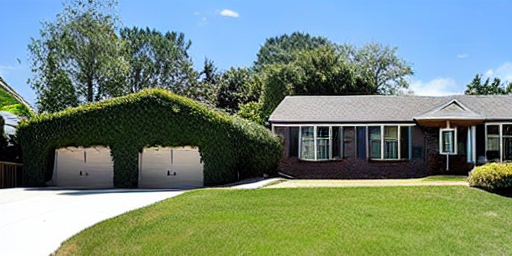

In [17]:
height = 256  # Set height
width = 512  # Set width


image_1 = txt_2_img_pipe(prompt[],negative_prompt=negative_prompt, guidance_scale=13, num_inference_steps= 80, height=height, width=width).images[0]
image_1.save('image_1.png')

# Show the image
image_1

## N°2 and followings

In [4]:
# Load the pre-trained model
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16)
img2img_pipe.to('cuda')


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1-base",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
# Prepare initial image and prompt
init_image = Image.open("image_1.png").convert("RGB")

### MODIFY IMAGE WITH NEXT WORD.
Input = previous image, next prompt word

In [60]:
# TODO FUNCTION OUT OF IT

In [59]:
words = prompt.split()

strength = 0.8  # How much the original image is preserved
guidance_scale = 7 # How closely the image should match the prompt

# Set the initial image as the starting point
current_image = Image.open("image_1.png").convert("RGB")

# Iterate over each word in the prompt
for i, word in enumerate(words):

    output = img2img_pipe(
        prompt=word,  
        negative_prompt=negative_prompt,
        image=current_image, 
        strength=strength,
        guidance_scale=guidance_scale
    ).images[0]

    # Save the current output image
    output_filename = f"output_image_{i+1}.jpg"
    output.save(output_filename)
    
    # Use the current output image as the input for the next iteration
    current_image = output

    print(f"Saved image: {output_filename}")

  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_image_1.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_image_2.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_image_3.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_image_4.jpg


  0%|          | 0/40 [00:00<?, ?it/s]

Saved image: output_image_5.jpg


### EXTEND IMAGE WITH NEXT WORD.
Input = previous image, next prompt word

In [76]:
words = prompt.split()

# Step 2: Crop the top part of the initial image (e.g., top 1/3 for outpainting)
top_part = init_image.crop((0, 0, init_image.width, init_image.height // 3))

# Step 3: Generate the expanded image (outpainting)
# Resize the top part to match input size for the model (if needed)
expanded_width = init_image.width
top_part.save('top_part.png')

  0%|          | 0/37 [00:00<?, ?it/s]

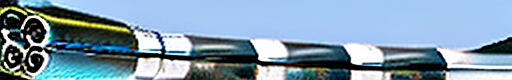

In [66]:
# Use the top part as the "input" image for outpainting
expanded_image = img2img_pipe(
    prompt=words[1],
    negative_prompt=negative_prompt,
    image=top_part,  # Use only the top part of the image
    strength=0.75,  # How much the model should alter the image
    guidance_scale=7.5  # Adjust the guidance scale for better adherence to the prompt
).images[0]


In [73]:
# Define the desired expanded size (512x300)
expanded_size = (1024, 256)

# Resize the top part to match the desired input size
top_part = top_part.resize(expanded_size)

# Generate the expanded content
expanded_image = img2img_pipe(
    prompt=words[1],
    negative_prompt=negative_prompt,
    image=top_part,
    strength=0.75,
    guidance_scale=7.5
).images[0]

expanded_image.save("expanded_only.jpg")


  0%|          | 0/37 [00:00<?, ?it/s]

In [81]:
# Load the inpainting pipeline
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [92]:
# Define the new canvas size (extend height upwards)
new_height = original_image.height + 256  # Add 256 pixels at the top
new_width = original_image.width
canvas = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Create larger canvas
canvas.paste(original_image, (0, 256))  # Place the original image at the bottom

# Create a mask for the blank area (the top part of the canvas)
mask = Image.new("L", (new_width, new_height), 0)  # Black (preserve original)
draw = ImageDraw.Draw(mask)
draw.rectangle([0, 0, new_width, 256], fill=255)  # White (generate area at top)

# Use the input image's top edge to guide the generation
prompt = words[1]

# Generate new content for the blank area
result = inpaint_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=canvas,
    mask_image=mask,
    strength=1.0,  # Full flexibility to generate new content
    guidance_scale=7.5
).images[0]

# Save the final result
result.save("expanded_upward_image.jpg")

  0%|          | 0/50 [00:00<?, ?it/s]

In [61]:
# Make a collage?

In [55]:
# ETERNAL RIGHT SCROLL OR BOTTOM, ETC.
# Prompt[:1] --> image1 --> right part of image1 + prompt[1:2] + style of image1 and noise/random --> image2 --> right part of image2 + prompt[2:3] + style of image 1...

In [ ]:
# ZOOM OUT OF ZOOM IN
# prompt[:1] --> image1 --> image1 + zoom out (bigger picture) --> 

In [ ]:
batch_prompts = [
    "A magical forest with glowing mushrooms and fairies at night",
    "A futuristic robot standing in a neon-lit room, highly detailed",
    "A serene mountain landscape with a river during sunrise"
]

images = pipeline(batch_prompts)

for i, img in enumerate(images.images):
    img.save(f"image_{i}.png")
